In [1]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import cartopy
from pynextsim.irregular_grid_interpolator import IrregularGridInterpolator
import pynextsim.lib as nsl
from pyproj import Proj

dst_proj = Proj(proj='stere', a=6378.273e3, b=6378.273e3*np.sqrt(1-0.081816153**2), lon_0=-45., lat_0=90., lat_ts=60.)

plot_crs = cartopy.crs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=60)

def gen_uniform_grid(xstart, xend, ystart, yend, dx):
    RE = 6378273.
    xcoord = np.arange(xstart, xend, dx*1e3)
    ycoord = np.arange(ystart, yend, dx*1e3)
    y, x = np.meshgrid(ycoord, xcoord)
    return x, y

def pwrspec2d(field):
    nx, ny = field.shape
    FT = np.zeros((nx, ny), dtype=complex)
    nupx = int(np.ceil((nx+1)/2))
    nupy = int(np.ceil((ny+1)/2))
    nup = max(nupx, nupy)
    wnx = generate_fft_index(nx)
    wny = generate_fft_index(ny)
    ky, kx = np.meshgrid(wny, wnx)
    k2d = np.sqrt((kx*(nup/nupx))**2 + (ky*(nup/nupy))**2)
    FT = np.fft.fft2(field) 
    P = (np.abs(FT)/nx/ny)**2
    wn = np.arange(0.0, nup)
    pwr = np.zeros((nup))
    for w in range(nup):
        pwr[w] = np.sum(P[np.where(np.ceil(k2d)==w)])
    return wn, pwr

def generate_fft_index(n):
  nup = int(np.ceil((n+1)/2))
  if n%2 == 0:
    wn = np.concatenate((np.arange(0, nup), np.arange(2-nup, 0)))
  else:
    wn = np.concatenate((np.arange(0, nup), np.arange(1-nup, 0)))
  return wn

In [30]:
import datetime
t = datetime.datetime.strptime('202203010000', '%Y%m%d%H%M')

In [31]:
filename='/Users/yueng/mnt/nersc/sim/data/ECMWF_forecast_arctic/{:04d}/{:02d}/ec2_start{:04d}{:02d}{:02d}.nc'.format(t.year, t.month, t.year, t.month, t.day)
f = Dataset(filename)
u = f['10U'][0, :, :]
f = Dataset(filename)
v = f['10V'][0, :, :]
latitude = f['lat'][:]
longitude = f['lon'][:]
lon, lat = np.meshgrid(longitude, latitude)

In [32]:
tmp = plot_crs.transform_points(cartopy.crs.PlateCarree(), lon, lat)
x1 = tmp[:,:,0]
y1 = tmp[:,:,1]
u1, v1 = nsl.transform_vectors(dst_proj, x1, y1, u, v, fill_polar_hole=True)

In [33]:
dx = 20 ##km
x2, y2 = gen_uniform_grid(-2.5e6, 3e6, -2e6, 2.5e6, dx)
igi = IrregularGridInterpolator(x1, y1, x2, y2)
u2 = igi.interp_field(u1)
v2 = igi.interp_field(v1)

In [34]:
f1 = Dataset("https://thredds.met.no/thredds/dodsC/aromearcticarchive/{:04d}/{:02d}/{:02d}/arome_arctic_full_2_5km_{:04d}{:02d}{:02d}T{:02d}Z.nc".format(t.year, t.month, t.day, t.year, t.month, t.day, t.hour))
lats = f1['latitude'][:, :]
lons = f1['longitude'][:, :]
us = f1['x_wind_10m'][0, 0, :, :]
vs = f1['y_wind_10m'][0, 0, :, :]

#f2 = Dataset("https://thredds.met.no/thredds/dodsC/aromearcticarchive/2022/02/01/arome_arctic_full_2_5km_20220201T00Z.nc")
#us = f2['x_wind_10m'][48, 0, :, :]
#vs = f2['y_wind_10m'][48, 0, :, :]

tmp = plot_crs.transform_points(cartopy.crs.PlateCarree(), lons, lats)
xs = tmp[:,:,0]
ys = tmp[:,:,1] 

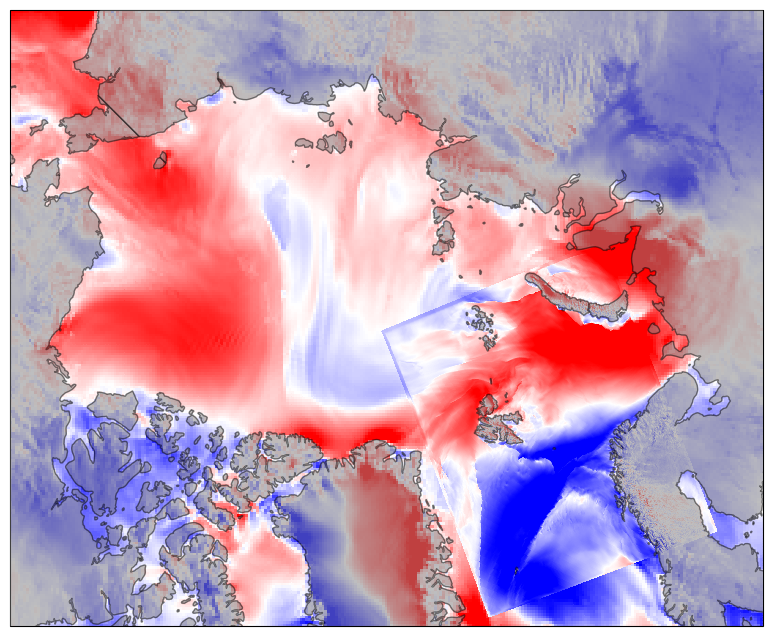

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8), subplot_kw={'projection': plot_crs})
im = ax.pcolor(x2, y2, u2, vmin=-10, vmax=10, cmap='bwr')
im = ax.pcolor(xs, ys, us, vmin=-10, vmax=10, cmap='bwr')
ax.add_feature(cartopy.feature.LAND, facecolor='gray', edgecolor='black', zorder=10, alpha=0.5)

Text(0.5, 0, 'wavelength (km)')

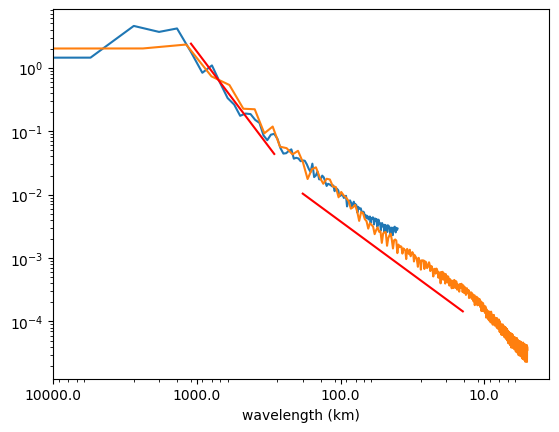

In [36]:
fig, ax = plt.subplots(1, 1)

#u2[np.where(np.isnan(u2))] = 0.
#v2[np.where(np.isnan(v2))] = 0.
wn, pwr_u2 = pwrspec2d(u2[:, :])
wn, pwr_v2 = pwrspec2d(v2[:, :])

ax.loglog(wn, 0.5*(pwr_u2+pwr_v2))

#us2[np.where(np.isnan(us2))] = 0.
#vs2[np.where(np.isnan(vs2))] = 0.
wn, pwr_us = pwrspec2d(us[:, :])
wn, pwr_vs = pwrspec2d(vs[:, :])

sf = 5500./2375.
ax.loglog(wn*sf, 0.5*(pwr_us+pwr_vs)/sf/sf)

##ref lines
wn1 = np.arange(5., 20., 2)
ax.loglog(wn1, 3e2*wn1**-3, 'r')
wn2 = np.arange(30., 400., 20)
ax.loglog(wn2, 3*wn2**(-5/3), 'r')

wl = np.array([1e4, 1e3, 1e2, 1e1])
ax.set_xticks(5500/wl)
ax.set_xticklabels(wl)
ax.set_xlabel('wavelength (km)')